# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

Utils has a solid API for building these modular frameworks and training them, and we will use this very well implemented framework as opposed to "reinventing the wheel."  This includes using the Solver, various utility functions, and the layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [65]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  10.002174918476616
Mean of train-time output:  9.993513678023765
Mean of test-time output:  10.002174918476616
Fraction of train-time output set to zero:  0.700284
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  10.002174918476616
Mean of train-time output:  10.005049747529467
Mean of test-time output:  10.002174918476616
Fraction of train-time output set to zero:  0.399692
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  10.002174918476616
Mean of train-time output:  10.006297614575843
Mean of test-time output:  10.002174918476616
Fraction of train-time output set to zero:  0.24988
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [68]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.4456108919504717e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [73]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0.5, 0.75, 1.0]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              weight_scale=5e-2, dtype=np.float64,
                              dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    print('\n')

Running check with dropout =  0.5
Initial loss:  2.2978802381633017
W1 relative error: 1.4081197358343105e-06
W2 relative error: 2.2537390027621073e-08
W3 relative error: 4.1035828818284274e-08
b1 relative error: 3.0008797991394704e-08
b2 relative error: 1.154024377991818e-09
b3 relative error: 1.2912061432212848e-10


Running check with dropout =  0.75
Initial loss:  2.308234140616203
W1 relative error: 2.6453375662528657e-07
W2 relative error: 2.2868666671395663e-07
W3 relative error: 2.2239751604049376e-07
b1 relative error: 7.112910572926549e-09
b2 relative error: 5.347954717817801e-09
b3 relative error: 1.0886215791527195e-10


Running check with dropout =  1.0
Initial loss:  2.3066226083055312
W1 relative error: 2.998747146522704e-07
W2 relative error: 5.530329156238169e-07
W3 relative error: 8.243368547047246e-08
b1 relative error: 1.5773080094048574e-08
b2 relative error: 6.4687893661983096e-09
b3 relative error: 1.223192314770519e-10




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [76]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0.6, 1.0]
for dropout in dropout_choices:
    model = FullyConnectedNet([100, 100, 100], dropout=dropout)

    solver = Solver(model, small_data,
                    num_epochs=25, batch_size=100,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 5e-4,
                    },
                    verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.304661
(Epoch 0 / 25) train acc: 0.172000; val_acc: 0.161000
(Epoch 1 / 25) train acc: 0.160000; val_acc: 0.152000
(Epoch 2 / 25) train acc: 0.214000; val_acc: 0.157000
(Epoch 3 / 25) train acc: 0.238000; val_acc: 0.201000
(Epoch 4 / 25) train acc: 0.264000; val_acc: 0.227000
(Epoch 5 / 25) train acc: 0.334000; val_acc: 0.263000
(Epoch 6 / 25) train acc: 0.354000; val_acc: 0.250000
(Epoch 7 / 25) train acc: 0.360000; val_acc: 0.290000
(Epoch 8 / 25) train acc: 0.388000; val_acc: 0.300000
(Epoch 9 / 25) train acc: 0.398000; val_acc: 0.287000
(Epoch 10 / 25) train acc: 0.418000; val_acc: 0.298000
(Epoch 11 / 25) train acc: 0.464000; val_acc: 0.314000
(Epoch 12 / 25) train acc: 0.488000; val_acc: 0.297000
(Epoch 13 / 25) train acc: 0.524000; val_acc: 0.308000
(Epoch 14 / 25) train acc: 0.544000; val_acc: 0.329000
(Epoch 15 / 25) train acc: 0.546000; val_acc: 0.320000
(Epoch 16 / 25) train acc: 0.596000; val_acc: 0.311000
(Epoch 17 / 25) train acc: 0.588000; val

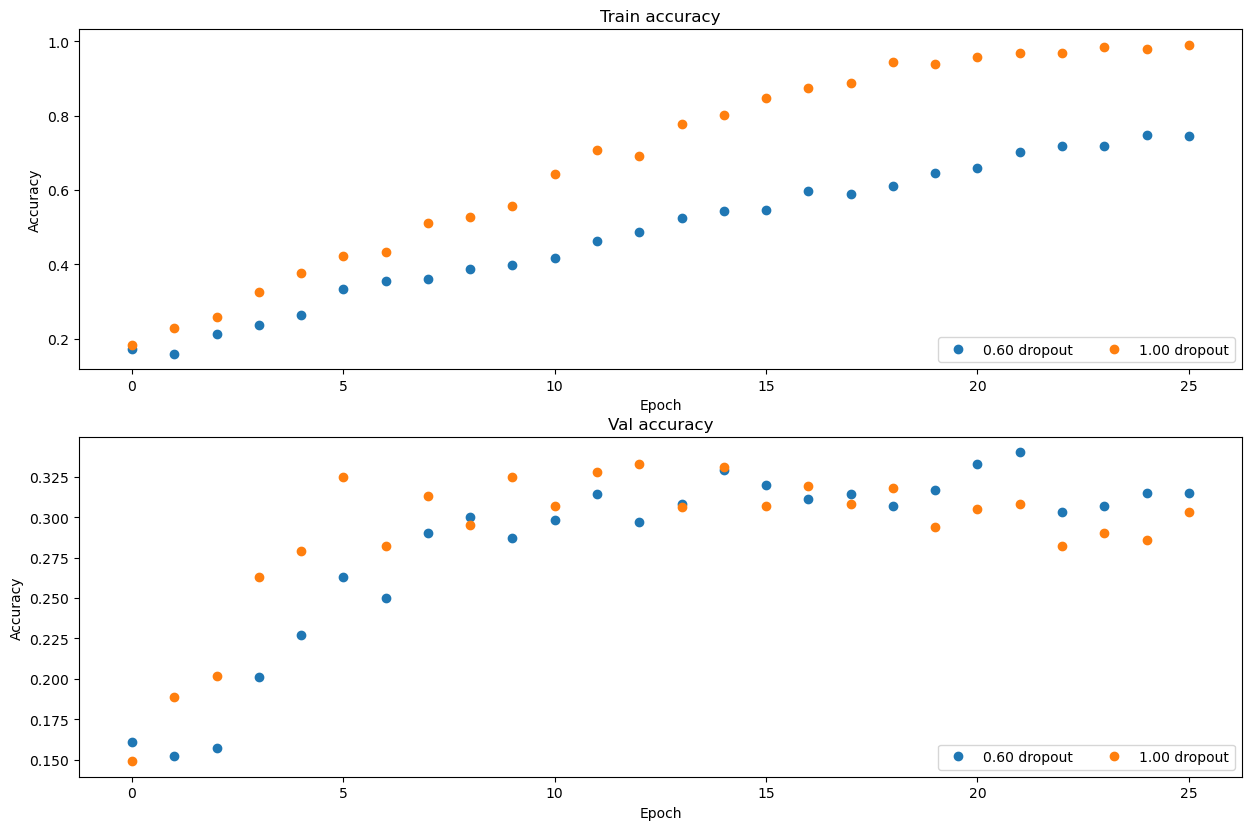

In [77]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:
Yes dropout is performing regularization. The dropout model's training accuracy is lower than the training accuracy of the model without dropout. However, the validation accuracy for the model with dropout and the one without dropout are similar, with the accuracy for the model with dropout marginally higher. 

By randomly keeping certian neurons in each layer and dropping others, dropout regularizes each hidden unit, so it performs worse on the training set (prevents overfitting), but generalizes well.

##### Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 23%, 1) 
where if you get 55% or higher validation accuracy, you get full points.

In [82]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #

optimizer = 'adam'

layer_dims = [500, 500, 500]
weight_scale = 0.01
learning_rate = 2e-3
lr_decay = 0.95
dropout = 0.7
reg_factor = 0

model = FullyConnectedNet(layer_dims, weight_scale=weight_scale, dropout=dropout, reg=reg_factor, use_batchnorm=True)

solver = Solver(model, data,
                num_epochs=10, batch_size=100,
                update_rule=optimizer,
                optim_config={
                  'learning_rate': learning_rate,
                },
                lr_decay=lr_decay,
                verbose=True, print_every=100)
solver.train()

y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print('Validation set accuracy: {}'.format(np.mean(y_val_pred == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_pred == data['y_test'])))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

(Iteration 1 / 4900) loss: 2.292121
(Epoch 0 / 10) train acc: 0.114000; val_acc: 0.150000
(Iteration 101 / 4900) loss: 1.773295
(Iteration 201 / 4900) loss: 1.733659
(Iteration 301 / 4900) loss: 1.427775
(Iteration 401 / 4900) loss: 1.566295
(Epoch 1 / 10) train acc: 0.482000; val_acc: 0.458000
(Iteration 501 / 4900) loss: 1.515206
(Iteration 601 / 4900) loss: 1.494222
(Iteration 701 / 4900) loss: 1.363037
(Iteration 801 / 4900) loss: 1.538717
(Iteration 901 / 4900) loss: 1.481794
(Epoch 2 / 10) train acc: 0.548000; val_acc: 0.505000
(Iteration 1001 / 4900) loss: 1.262693
(Iteration 1101 / 4900) loss: 1.433086
(Iteration 1201 / 4900) loss: 1.311563
(Iteration 1301 / 4900) loss: 1.272225
(Iteration 1401 / 4900) loss: 1.522078
(Epoch 3 / 10) train acc: 0.573000; val_acc: 0.535000
(Iteration 1501 / 4900) loss: 1.525663
(Iteration 1601 / 4900) loss: 1.280905
(Iteration 1701 / 4900) loss: 1.384414
(Iteration 1801 / 4900) loss: 1.379152
(Iteration 1901 / 4900) loss: 1.199921
(Epoch 4 / 10) t